In [462]:
import torch
from torchvision.datasets import CIFAR10
import torchvision.transforms as T
from typing import *
from torch import Tensor, nn
from tqdm.notebook import tqdm
import copy

path = "/tmp/cifar"

### A Toy Dataset

We use just the R,G,B channels of some images as ground truth x values

In [426]:
class CifarDataset(torch.utils.data.Dataset):
    def __init__(self, f: Callable, path: str = path, sigma: float = 0.05, train: bool = True):
        """
        f: (Nonlinear) function to to applied on x labels to get y values.
        path: Temp Dir to store images
        sigma: Noise sigma, to be added on y
        train: Use Cifar train split, otherwise use test split
        
        Will augment by Flips and Colorjitter during training. 
        x labels are normalized to mean=0, std=1 (-ish) before applying f.
        
        """
        if train:
            transform = T.Compose((T.RandomVerticalFlip(), T.RandomHorizontalFlip(), T.ColorJitter(0.1, 0.1, 0.1, 0.1), T.ToTensor(), T.Normalize((0.48, 0.48, 0.44), (0.25, 0.25, 0.26))))
        else:
            transform = T.Compose((T.ToTensor(), T.Normalize((0.48, 0.48, 0.44), (0.25, 0.25, 0.26))))
        self.ds = CIFAR10(path, download=True, transform=augment, train=train)
        self.f = f
        self.sigma = sigma
        self.train = train

    def __getitem__(self, idx):
        x = self.ds[idx][0]
        y = f(x)
        if self.train:
            noise=self.sigma*torch.randn_like(y)
        else:
            noise=(self.sigma*np.random.default_rng(idx).normal(size=y.shape)).astype(np.float32)
        ynoisy = y+noise
        return ynoisy, x
    def __len__(self):
        return len(self.ds)

In [488]:
## Our Nonlinear Function with 3 inputs and 5 outputs:
#f(x1,x2,x3) = (5+x1)*sin(t*x2) + (1+x3)**2 

def f(x):
    t=torch.tensor((-3.,-1.5,0.,1.5,3.))
    t=t.squeeze()[...,None,None].to(device=x.device)
    x1,x2,x3=torch.split(x,1,-3)
    y=(5+x1)*torch.sin(t*x2) + (1+x3)**2
    return y

In [411]:
dataloader=torch.utils.data.DataLoader(CifarDataset(f),batch_size=32,shuffle=True,num_workers=4)

Files already downloaded and verified


## Validation Function

We use a simple Validation that just returns the MSE for all three parameters over the test split of our dataset.

In [427]:
def test(net,testDs):
    dataloader=torch.utils.data.DataLoader(testDs,batch_size=32,shuffle=False,num_workers=4)
    for i, batch in enumerate(dataloader):
        (y_noise, x_gt) = (i.cuda() for i in batch)
        x_pred=net(y_noise)
        loss = nn.functional.mse_loss(x_pred,x_gt)
        losses.append(torch.nn.functional.mse_loss(x_gt,x_pred,reduction='none').mean((0,-1,-2)).detach().cpu().numpy())
    return np.array(losses).mean(0)

In [428]:
testDs=CifarDataset(f,train=False)


Files already downloaded and verified


## A Simple Network

In [412]:
net=nn.Sequential(
    nn.Conv2d(5,128,3,padding="same"), nn.ReLU(True),
    nn.Conv2d(128,128,3,padding="same"), nn.ReLU(True),
    nn.Conv2d(128,128,3,padding="same"), nn.ReLU(True),
    nn.Conv2d(128,3,1,padding="same"),
).cuda()

optim=torch.optim.Adam(net.parameters(),lr=1e-4)

losses=[]
for epoch in range(1):
    pbar = tqdm(dataloader)
    for i, batch in enumerate(pbar):
        (y_noise, x_gt) = (i.cuda() for i in batch)
        optim.zero_grad()
        x_pred=net(y_noise)
        loss = nn.functional.mse_loss(x_pred,x_gt)
        loss.backward()
        if i%10==0:
            pbar.set_description(f" loss: {loss.item():.5f}")
            losses.append(torch.nn.functional.mse_loss(x_gt,x_pred,reduction='none').mean((0,-1,-2)).detach().cpu().numpy())
        optim.step()
        

  0%|          | 0/1563 [00:00<?, ?it/s]

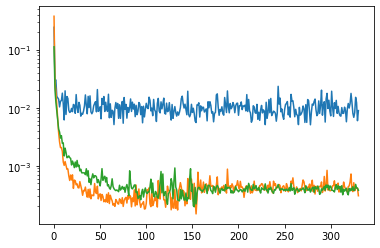

In [429]:
import matplotlib.pyplot as plt
plt.semilogy(losses)

## Just Using The Network

In [430]:
r=test(net,testDs)
r

# This are the MSE Errors of the the parameters

array([0.01031939, 0.00111722, 0.00070511], dtype=float32)

## Simple NonLinear Regression

In [399]:
def NonLinearRegressor(f,y,x0=None):
    if x0 is None:
        x=torch.zeros(y.shape[0],3,*y.shape[2:],requires_grad=True,device=y.device)
    else:
        x=x0.detach().clone().to(device=y.device).requires_grad_(True)
    optim=torch.optim.LBFGS((x,),max_iter=200,history_size=20,line_search_fn="strong_wolfe")

    def loss():
        optim.zero_grad()
        l=torch.nn.functional.mse_loss(f(x),y)
        l.backward()
        return l
    optim.step(loss)

    return x.detach()

In [431]:
regressor=lambda y: NonLinearRegressor(f,y)
test(regressor,testDs)

array([0.01365111, 0.001347  , 0.00049624], dtype=float32)

## Using The Network output as starting point

In [432]:
regressorwithx0=lambda y:NonLinearRegressor(f,y,x0=net(y))
test(regressorwithx0,testDs)

array([0.01394847, 0.00104001, 0.00039014], dtype=float32)

## Using the Network as Regularizer

In [402]:
def RegularizedNonLinearRegressor(f,y,net,strength):
    xreg=net(y).detach().clone()
    x=xreg.detach().clone().to(device=y.device).requires_grad_(True)
    optim=torch.optim.LBFGS((x,),max_iter=200,history_size=20,line_search_fn="strong_wolfe")

    def loss():
        optim.zero_grad()
        l=torch.nn.functional.mse_loss(f(x),y)+strength*torch.nn.functional.mse_loss(x,xreg)
        l.backward()
        return l
    optim.step(loss)

    return x.detach()

In [433]:
test(lambda y: RegularizedNonLinearRegressor(f,y,net,0.1),testDs)

array([0.01221109, 0.00084211, 0.00032594], dtype=float32)

## Lets Summarize so far

- Using the Neural Network as a Regularizer and as the Starting Point for a Regression improves the MSE Loss in all parameters compared to 
    - 'just a network' or 
    - 'just a regression'
- But we had to choose the regularisation strength manually and we trained the network beforehand
- Next Steps: End-to-End train the whole thing!

## Differentiable Non Linear Optimisation

Goal: 
Do the same as in the last step, i.e. use the CNN to predict a regularisation for the regression. But Optimize the network weights, such that the final result after the regression is best. Also, we want to learn the regularisation strength.

### Helper Functions

In [435]:
# Just a simple CG Solver to solve Problems like Ax=b with A spd for x

def norm(x: Tensor, dims: Optional[List[int]] = None):
    # ||x||_2^2
    x = torch.abs((x * x.conj()))
    if dims is None:
        return x.sum()
    else:
        return x.sum(dims, keepdim=True)

def cg(A: Callable, b: Tensor, x0: Optional[Tensor] = None, tol: float = 1e-8, maxiter=50, dims=(-1,-2,)):
    # conjugate gradient solver for linear problem
    x = b.clone().detach() if x0 is None else x0.clone()
    r = b - A(x)
    p = r
    rsold = norm(r, dims)
    if torch.max(rsold) < (tol or 1e-12):
        return x
    for i in range(maxiter):  # max iterations
        Ap = A(p)
        alpha = rsold * 1 / ((p.conj() * Ap).sum(dims, keepdims=True))
        alpha[torch.isnan(alpha)] = 0
        x.addcmul_(alpha, p)
        r.addcmul_(alpha, Ap, value=-1)
        rsnew = norm(r, dims)
        if tol is not None:
            if torch.max(rsnew) < tol:
                break
        beta = torch.nan_to_num_(rsnew / rsold) 
        p = r + beta * p
        rsold = rsnew
    x[torch.isnan(x)] = 0
    return x

### Differentiabe Non-Linear-Regression Layer



We can solve the Regression Problem with BFGS (or any other solver)

To use it in an end-to-end training, we need to propagate the gradients from the optimal point found be the regression (xprime) to the parameters.
In our example, we only care about propagating to
- lambda --> We want to learn the optimal lambda by SGD
- xreg --> This is the CNN output and we want to optimize the Network weights with SGD

but in my paper, for example, I also need to propagate the gradient to y, as this is the result of solving another subproblem (with a CNN) . So the Layer should do that as well.


The layer uses pytorch autograd functionality to
    - apply the Hessian to a vector
    - find the derivative of the gradient wrt to the parameters we want to propagate to.
This way, we never have to manually think about the gradient (or hessian) of our signal function

In [526]:
class BFGS(torch.autograd.Function):
    """
    Wrapper around optim.bfgs to make it differentiable
    
    Solves argmin_x ||f(x)-y ||^2 + l*||x-xreg||^2 with BFGS in the forward pass
    and calculates the gradients wrt y, l and xreg in the backward pass
    """

    @staticmethod
    def forward(ctx, f: Callable, y: Tensor, xreg: Tensor, l: Tensor):
        """
        BFGS
        """
        ctx.f = f

        x = xreg.detach().clone().requires_grad_(True) # Use xreg as initial point for regresison
        xreg = xreg.detach()
        y = y.detach()
        lscalar = l.item()
        
        # Solve the inner Problem, this could be any solver!
        optim = torch.optim.LBFGS([x], history_size=10, max_iter=200, tolerance_change=1e-15, tolerance_grad=1e-15, lr=1.0, line_search_fn="strong_wolfe")  # *x.flatten(0,-2)
        def closure():
            x.grad = None
            fx = f(x)
            a = torch.nn.functional.mse_loss(fx, y, reduction="sum") # Data Consistency
            b = lscalar * torch.nn.functional.mse_loss(x, xreg, reduction="sum") #Regularisation 
            output = a + b
            output.backward()
            return output
        optim.step(closure)
        
        x.grad = None
        ctx.save_for_backward(x, y, xreg, l)
        return torch.clip(torch.nan_to_num(x), -1e6, 1e6)

    @staticmethod
    def backward(ctx, grad):

        xprime, y, xreg, l = ctx.saved_tensors
        xprime = xprime.detach().clone().requires_grad_(True)
        params = (y, xreg, l)

        # Only wrt Parameters that need a gradient will later on be differentiated and need to have requires_grad_(True)
        params = [p.detach().clone().requires_grad_(True) if ctx.needs_input_grad[i + 1] else p.detach() for i, p in enumerate(params)]
        dparams = [p for p in params if p.requires_grad]  # Parameters that need a gradient

        # Repeat the Objetive function used in the forward pass
        f = ctx.f
        (y, xreg, l) = params
        # Here the objective functoin should be the same as in the forward!!
        objective = lambda x: torch.nn.functional.mse_loss(f(x), y, reduction="sum") + l * torch.nn.functional.mse_loss(x, xreg, reduction="sum")

        A = lambda v: torch.autograd.functional.vhp(objective, xprime, v=v)[1]  # Hessian Operator
        iHv = cg(A, grad, maxiter=100, tol=1e-15, dims=tuple(range(-1, -xreg.ndim - 1, -1)))  # Solve H*iHv=grad

        with torch.enable_grad():  # Mixed Gradients for backward equation
            gt = torch.autograd.grad(objective(xprime), xprime, create_graph=True)[0]
            ggt = list(torch.autograd.grad(gt, dparams, -iHv))

        # We got everything, we just have to assumble our output and fill in None's where we did not calculate a gradient
        grad_output = [None]  # no gradient for f
        for need_grad in ctx.needs_input_grad[1:4]:
            if need_grad:
                w = ggt.pop(0)
                w = torch.clip(torch.nan_to_num(w), -1e6, 1e6)
                grad_output.append(w)
            else:
                grad_output.append(None)

        return tuple(grad_output)

In [540]:
class E2ENetwork(nn.Module):
    def __init__(self, f, net=None):
        super().__init__()
        if net is None:
            self.net = nn.Sequential(
                nn.Conv2d(5, 128, 3, padding="same"),
                nn.ReLU(True),
                nn.Conv2d(128, 128, 3, padding="same"),
                nn.ReLU(True),
                nn.Conv2d(128, 128, 3, padding="same"),
                nn.ReLU(True),
                nn.Conv2d(128, 3, 1, padding="same"),
            )
        else:
            self.net = copy.deepcopy(net)

        self.lambdaRaw = nn.Parameter(torch.tensor(1.0))
        self.softplus = nn.Softplus(beta=5)
        self.f = f

    @property
    def lam(self):
        """Enforce positivity by softplus on lambda"""
        return self.softplus(self.lambdaRaw)

    def forward(self, y):
        xreg = net(y)
        x = BFGS.apply(self.f, y, xreg, self.lam)
        return x

In [542]:
net2=E2ENetwork(f,net)

In [545]:
## Train the new end-to-end network
optim = torch.optim.Adam((dict(params=net2.net.parameters(), lr=1e-4), dict(params=(net2.lambdaRaw,), lr=1e-2)))

losses2 = []
for epoch in range(1):
    pbar = tqdm(dataloader)
    for i, batch in enumerate(pbar):
        (y_noise, x_gt) = (i.cuda() for i in batch)
        optim.zero_grad()
        x_pred = net2(y_noise)
        loss = nn.functional.mse_loss(x_pred, x_gt)
        loss.backward()
        if i % 5 == 0:
            pbar.set_description(f" loss: {loss.item():.5f}   lambda: {net2.lam.item():.5f}")
            losses2.append(torch.nn.functional.mse_loss(x_gt, x_pred, reduction="none").mean((0, -1, -2)).detach().cpu().numpy())
        optim.step()

  0%|          | 0/1563 [00:00<?, ?it/s]

In [547]:
test(net2,testDs)

array([0.0095421 , 0.00054289, 0.0002289 ], dtype=float32)

## Results

|Method     | MSE x1 |MSE x2  | MSE x3 |
------------|--------|--------|--------|
|Network    | 0.01031| 0.00111| 0.00070|
|fit        | 0.01365| 0.00134| 0.00049|
|Fit w. x0  | 0.01394| 0.00104| 0.00039|
|Reg. fit   | 0.01221| 0.00084| 0.00032|
|E2E Fit+Net| 0.00954| 0.00054| 0.00022|
